In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import collections
import gc
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.layers import Dropout, GaussianNoise, Input, UpSampling2D
from tensorflow.keras.models import Model, Sequential, load_model
import sklearn.model_selection
from copy import deepcopy

<h2> Data Preprocessing </h2>

In [2]:
start = time.time()
data = pd.read_csv("./train.csv")
X1 = data[data.columns[np.vectorize(lambda s: "start" in s)(data.columns.values)]]
X1 = X1.values.reshape(data.shape[0],25,25,1)
delta = data["delta"].values
X2 = np.zeros((data.shape[0],25*25*5))
for i in range(data.shape[0]):
    X2[i,(delta[i]-1)::5] = 1
temp = data[data.columns[np.vectorize(lambda s: "stop" in s)(data.columns.values)]].values
Y = np.zeros((data.shape[0],25*25*5))
for i in range(data.shape[0]):
    Y[i,(delta[i]-1)::5] = temp[i]
print("Preprocessing Exited in "+str(time.time()-start)+" seconds")
data.shape, X1.shape, X2.shape, Y.shape

Preprocessing Exited in 8.210934162139893 seconds


((50000, 1252), (50000, 25, 25, 1), (50000, 3125), (50000, 3125))

<h2>Approach 1: N-Step Convolver</h2><br/>
We attempt to use a series of convolutions that maintain same padding to move from current Game of Life state to the outputs states. Specifically, we create a weighted_mean_squared_error custom loss function, wrapped inside a call-back and a class that decrements the higher weight to positive class over time.

In [14]:
class WeightedMSE:
    def __init__(self, origweight, targetweight, decayepoch):
        self.weight = origweight
        self.decay = (origweight-targetweight)/(decayepoch-1)
        self.endepoch = decayepoch
    def loss(self, ytrue, ypred):
        diff = ytrue-ypred
        poserr = tf.map_fn(lambda s: tf.reduce_sum(tf.math.square(s[s>0])), diff)*self.weight
        negerr = tf.map_fn(lambda s: tf.reduce_sum(tf.math.square(s[s<0])), diff)
        return tf.reduce_mean(poserr)+tf.reduce_mean(negerr)
    def update_weight(self, epoch):
        if (epoch<self.endepoch) and (epoch!=0):
            self.weight-=self.decay
class LossCallBack(keras.callbacks.Callback):
    def __init__(self, lossclass):
        self.lossclass = lossclass
    def on_epoch_end(self, epoch, logs):
        self.lossclass.update_weight(epoch)

In [15]:
def build_model(lossfunc="mean_squared_error"):
    tf.keras.backend.clear_session()
    deltainp = Input((25*25*5), dtype=tf.float32) #Delta Mask
    gofinp = Input((25,25,1)) #Game of Life Board
    #Increasing Filters to Capture Relationships
    conv1 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(gofinp)
    max1 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv1)
    conv2 = Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max1)
    max2 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv2)
    #Reducing Filters to Final Output
    conv3 = Conv2D(filters=32, kernel_size=(7,7), strides=(1,1), padding="same", activation="relu")(max2)
    max3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding="same")(conv3)
    final = Conv2D(filters=5, kernel_size=(7,7), strides=(1,1), padding="same", activation=None)(max3)
    #Evaluate Required Board
    final = tf.keras.layers.Activation(activation="sigmoid")(Flatten()(final))
    final = Flatten()(tf.math.multiply(final, deltainp))
    model = Model(inputs=[gofinp, deltainp], outputs=final)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3), loss=lossfunc)
    return model
build_model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 32)   1600        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 25, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 25, 64)   100416      max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
def plotter(model, hist, lossfntitle):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title(lossfntitle+" over Time")
    plt.xlabel("Epoch")
    plt.ylabel("Value of Loss Function")
    pd.Series(hist.history["loss"]).plot(label="Train Data")
    pd.Series(hist.history["val_loss"]).plot(label="Validation Data")
    plt.legend(loc="best")
    plt.subplot(1,2,2)
    conf = np.zeros((2,2))
    res = model.predict([X1[40000:],X2[40000:]])
    for i in range(res.shape[0]):
        pred = deepcopy(res[i,(delta[40000+i]-1)::5])
        pred[pred<(2/3)] = 0
        pred[pred>(2/3)] = 1
        corr = Y[40000+i,(delta[40000+i]-1)::5]
        for i in range(2):
            for j in range(2):
                conf[i,j] += np.sum((corr==j)&(pred==i))
    ax = sns.heatmap(conf/np.sum(conf, axis=0).reshape(1,-1)*100, annot=True, cmap="Blues", fmt=".1f")
    for t in ax.texts: t.set_text(t.get_text() + "%")
    plt.xlabel("Real Cell Label")
    plt.ylabel("Predicted Cell Label")
    plt.title("Confusion Matrix at Cut-off of 2/3")
    plt.show()

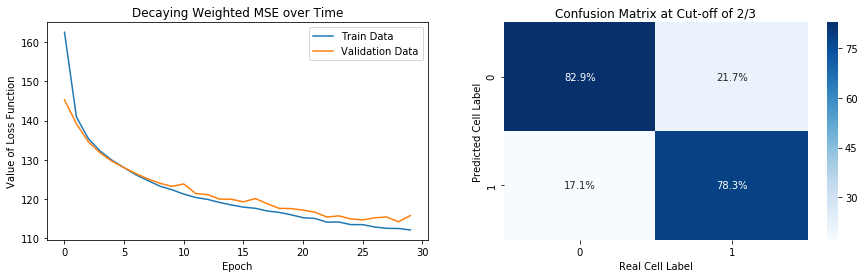

In [49]:
#Visualizing Results on First Fold
numepochs, decayepochs = 30, 22
lossclass = WeightedMSE(5, 1, decayepochs)
losscallback = LossCallBack(lossclass)
model = build_model(lossclass.loss)
hist = model.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback]) 
plotter(model, hist, "Decaying Weighted MSE")

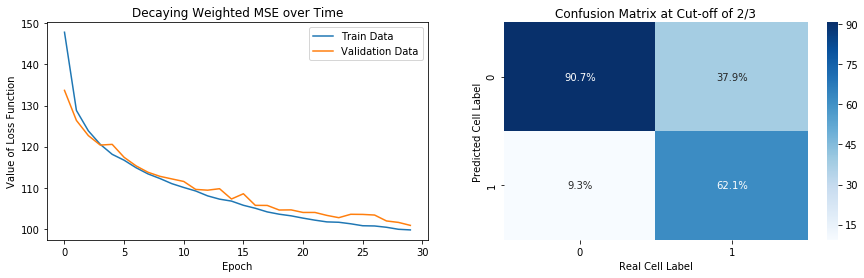

In [52]:
#Visualizing Results on First Fold - New Decay
numepochs, decayepochs = 30, 20
lossclass = WeightedMSE(4, 1, decayepochs)
losscallback = LossCallBack(lossclass)
model = build_model(lossclass.loss)
hist = model.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback])  
plotter(model, hist, "Decaying Weighted MSE")

In [92]:
#Modified version of categorical cross-entropy to capture imbalance
class LogEntropy:
    def __init__(self, origweight, targetweight, decayepoch):
        self.weight = origweight
        self.decay = (origweight-targetweight)/(decayepoch-1)
        self.endepoch = decayepoch
    def loss(self, ytrue, ypred):
        mask=ytrue-ypred
        newten = tf.where(mask<0, tf.math.log(1-ypred), ypred)
        newten = tf.where(mask>0, tf.math.log(newten)*self.weight, newten)
        err = tf.map_fn(lambda s: tf.reduce_sum(s), newten)
        return -tf.reduce_mean(err)
    def update_weight(self, epoch):
        if (epoch<self.endepoch) and (epoch!=0):
            self.weight-=self.decay

In [90]:
numepochs = 10
model = build_model(reverse_entropy)
hist = model.fit([X1[:40000],X2[:40000]],Y[:40000], batch_size=256, epochs=numepochs, 
                 #verbose=False,
                 validation_data=([X1[40000:], X2[40000:]], Y[40000:]), callbacks=[losscallback])  

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 234s 6ms/sample - loss: 217.1366 - val_loss: 192.6208
Epoch 2/10
40000/40000 [==============================] - 241s 6ms/sample - loss: 186.4926 - val_loss: 183.3493
Epoch 3/10
40000/40000 [==============================] - 260s 6ms/sample - loss: 179.5025 - val_loss: 177.7852
Epoch 4/10
40000/40000 [==============================] - 256s 6ms/sample - loss: 175.6109 - val_loss: 174.6974
Epoch 5/10
40000/40000 [==============================] - 238s 6ms/sample - loss: 172.6984 - val_loss: 172.3320
Epoch 6/10
40000/40000 [==============================] - 237s 6ms/sample - loss: 170.3237 - val_loss: 170.0585
Epoch 7/10
40000/40000 [==============================] - 239s 6ms/sample - loss: 168.0269 - val_loss: 168.0509
Epoch 8/10
40000/40000 [==============================] - 238s 6ms/sample - loss: 165.7457 - val_loss: 166.8199
Epoch 9/10
40000/40000 [==============================

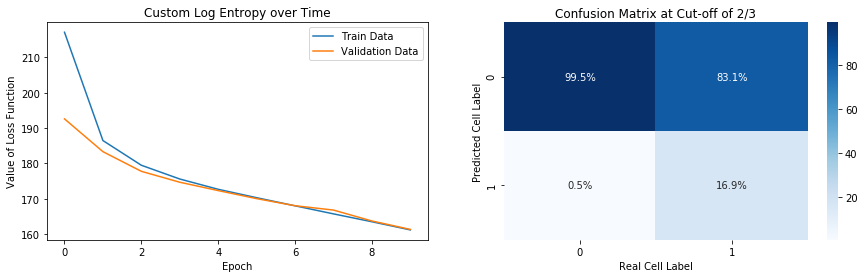

In [91]:
plotter(model, hist, "Custom Log Entropy")

<h2> Approach 2: CNN-Encoder-Decoder </h2>

In [153]:
tf.keras.backend.clear_session()
deltainp = Input((25,25,5), dtype=tf.float32) #Delta Mask
gofinp = Input((25,25,1)) #Game of Life Board
conv1 = Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(gofinp)
max1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv1)
conv2 = Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding="same", activation="relu")(max1)
max2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv2)
drp2 = Dropout(0.1)(max2)
conv3 = Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), padding="same", activation="elu")(drp2)
max3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid")(conv3)
up1 = UpSampling2D(size=(2,2), interpolation="nearest")(max3)
dec1 = Conv2DTranspose(filters=64, strides=(1,1), kernel_size=(5,5), padding="same", activation="elu")(up1)
up2 = UpSampling2D(size=(2,2), interpolation="nearest")(dec1)
dec2 = Conv2DTranspose(filters=32, strides=(1,1), kernel_size=(5,5), padding="same", activation="relu")(up2)
up3 = UpSampling2D(size=(2,2), interpolation="nearest")(dec2)
dec3 = Conv2DTranspose(filters=5, strides=(1,1), kernel_size=(2,2), activation="sigmoid")(up3)
final = Flatten()(tf.math.multiply(dec3, deltainp))
model = Model(inputs=[gofinp, deltainp], outputs=final)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss=weighted_mean_squared_error)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 25, 25, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 64)   51264       max_pooling2d[0][0]              
______________________________________________________________________________________________

<h2> Approach 3: LSTM-Based Sequence Generation